In [1]:
import os
from tqdm import tqdm
import IPython.display as ipd
import librosa
from glob import glob
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import pyloudnorm as pyln
from scipy import signal, linalg
import sklearn
from ipywidgets import interact
import urllib
import mir_eval

import torch
from pprint import pprint
from pyannote.audio import Pipeline

from sklearn import preprocessing
from sklearn import cluster

from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionErrorRate
%matplotlib inline

/Users/nuinashco/Projects/personal/ucu_audio_processing_course/.venv/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


# Data

In [2]:
wave_pathes = glob(
    "../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True
)

len(wave_pathes)

44242

In [3]:
sample_file = wave_pathes[0]
sample_audio, sample_audio_sr = librosa.load(sample_file, sr=None)

print(f"{sample_audio_sr=}")
ipd.Audio(sample_file)

sample_audio_sr=48000


# Reference model

In [4]:
model, utils = torch.hub.load(repo_or_dir="snakers4/silero-vad", model="silero_vad", force_reload=True)
get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/nuinashco/.cache/torch/hub/master.zip


In [5]:
speech_timestamps = get_speech_timestamps(read_audio(wave_pathes[0]), model)
print(speech_timestamps)

[{'start': 11296, 'end': 43488}]


In [6]:
help(get_speech_timestamps)

Help on function get_speech_timestamps in module silero_vad.utils_vad:

get_speech_timestamps(audio: torch.Tensor, model, threshold: float = 0.5, sampling_rate: int = 16000, min_speech_duration_ms: int = 250, max_speech_duration_s: float = inf, min_silence_duration_ms: int = 100, speech_pad_ms: int = 30, return_seconds: bool = False, visualize_probs: bool = False, progress_tracking_callback: Callable[[float], NoneType] = None, neg_threshold: float = None, window_size_samples: int = 512)
    This method is used for splitting long audios into speech chunks using silero VAD
    
    Parameters
    ----------
    audio: torch.Tensor, one dimensional
        One dimensional float torch.Tensor, other types are casted to torch if possible
    
    model: preloaded .jit/.onnx silero VAD model
    
    threshold: float (default - 0.5)
        Speech threshold. Silero VAD outputs speech probabilities for each audio chunk, probabilities ABOVE this value are considered as SPEECH.
        It is bet

In [7]:
import pandas as pd

# reference_speech_timestamps = []
# for wave_path in tqdm(wave_pathes):
#     reference_speech_timestamps.append(get_speech_timestamps(read_audio(wave_path), model))


# data_labeled = pd.DataFrame(
#     {
#         'path': wave_pathes,
#         'labels': reference_speech_timestamps
#     }
# )

# data_labeled.to_parquet("data/silero-vad-labels.parquet")


data_labeled = pd.read_parquet("data/silero-vad-labels.parquet")

data_labeled.head()

,path,labels
0,../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/...,"[{'end': 43488, 'start': 11296}]"
1,../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/...,"[{'end': 39904, 'start': 21024}]"
2,../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/...,"[{'end': 30176, 'start': 17952}, {'end': 92640..."
3,../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/...,"[{'end': 48096, 'start': 13856}]"
4,../../data/VCTK/VCTK-Corpus/VCTK-Corpus/wav48/...,"[{'end': 53216, 'start': 22048}, {'end': 87520..."


In [8]:
# lets search just start and end

data_labeled['labels'].apply(len).value_counts(normalize=True)

labels
1    0.938610
2    0.054948
3    0.005764
4    0.000452
0    0.000181
5    0.000045
Name: proportion, dtype: float64

# Preprocessing

In [9]:
ipd.Audio(sample_file)

In [10]:
sample_audio_prep_path = f'data/{sample_file.split("/")[-1].split(".")[0]}_prep.wav'

## Volume Normalization

In [11]:
def normalize_audio(signal):
    return signal / np.max(np.abs(signal))

In [12]:
sample_audio_norm = normalize_audio(sample_audio)

sf.write(sample_audio_prep_path, data=sample_audio_norm, samplerate=sample_audio_sr)
ipd.Audio(sample_audio_prep_path)

## Butter filter

In [13]:
def butter_filter(audio, sr, lowcut=300, highcut=3400, order=5):
    """Applies a bandpass Butterworth filter to keep only human speech frequencies."""
    nyquist = 0.5 * sr  # Nyquist frequency (half of sampling rate)
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, audio)


In [14]:
sample_audio_filter = butter_filter(
    audio=sample_audio_norm,
    sr=sample_audio_sr
)

sf.write(sample_audio_prep_path, data=sample_audio_filter, samplerate=sample_audio_sr)
ipd.Audio(sample_audio_prep_path)

# VAD

## Utils

In [15]:
def compute_energy(signal, frame_length=2048, hop_length=512):
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length).flatten()
    return rms * rms

In [16]:
def compute_zero_crossing_rate(signal, frame_length=2048, hop_length=512):
    return librosa.feature.zero_crossing_rate(signal, frame_length=frame_length, hop_length=hop_length).flat

In [17]:
def compute_spectral_flux(signal, frame_length=2048, hop_length=512):
    stft = np.abs(librosa.stft(signal, n_fft=frame_length, hop_length=hop_length))
    flux = np.sum((np.diff(stft, axis=1) ** 2), axis=0)
    return flux

## Check on one sample

In [18]:
# to compare, with no scale

sample_audio_filter = butter_filter(
    audio=sample_audio,
    sr=sample_audio_sr
)

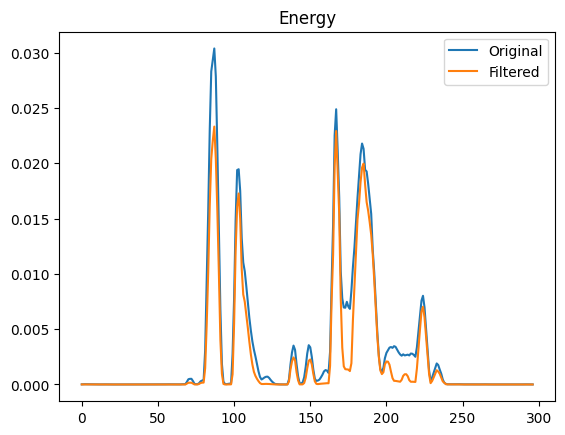

In [19]:
pd.Series(compute_energy(sample_audio)).plot(label="Original")
pd.Series(compute_energy(sample_audio_filter)).plot(label="Filtered")

plt.title("Energy")
plt.legend()

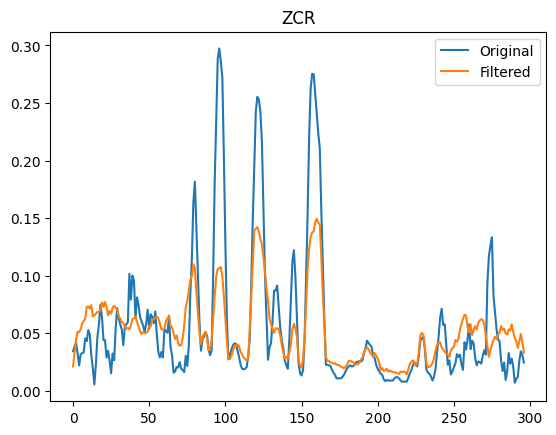

In [20]:
pd.Series(compute_zero_crossing_rate(sample_audio)).plot(label="Original")
pd.Series(compute_zero_crossing_rate(sample_audio_filter)).plot(label="Filtered")

plt.title("ZCR")
plt.legend()

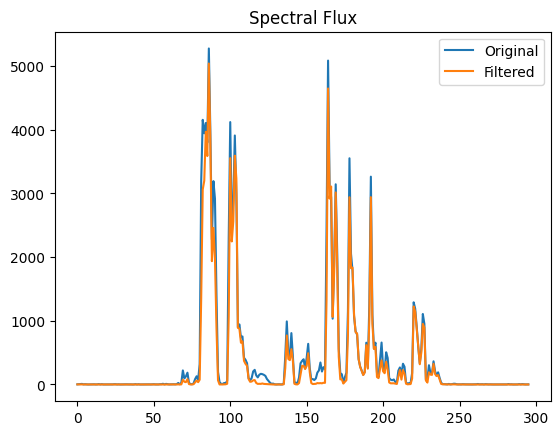

In [21]:
pd.Series(compute_spectral_flux(sample_audio)).plot(label="Original")
pd.Series(compute_spectral_flux(sample_audio_filter)).plot(label="Filtered")

plt.title("Spectral Flux")
plt.legend()

## Experiments

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
def min_max_scale(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X))

In [24]:
def calc_detection_error_rate(method, preprocess=False):
    metric = DetectionErrorRate()

    for file in tqdm(wave_pathes):
        # Load audio
        audio, sr = librosa.load(file, sr=None)

        if preprocess:
            audio = normalize_audio(audio)
            audio = butter_filter(audio, sr)

        # Get reference (Silero VAD)
        speech_timestamps = data_labeled.loc[data_labeled['path'] == file, "labels"].iloc[0]
        reference = Annotation()
        for speech in speech_timestamps:
            reference[Segment(speech["start"] / 16000, speech["end"] / 16000)] = "SPEECH"

        # Get hypothesis (K-Means VAD)
        hypothesis = Annotation()
        speech_start, speech_end = method(audio, sr)
        hypothesis[Segment(speech_start, speech_end)] = "SPEECH"

        # Compute Detection Error Rate (DER)
        _ = metric(reference, hypothesis)

    # Aggregate the performance over the whole test set
    return abs(metric)

### Energy

In [25]:
def energy_labels(signal, sr, frame_length=2048, hop_length=512, th=0.01):
    energy = compute_energy(signal=signal, frame_length=frame_length, hop_length=hop_length)
    energy_normal = min_max_scale(energy)
    labels = energy_normal > th

    speech_start = labels.argmax()
    speech_end = len(labels) - 1 - np.argmax(labels[::-1])

    frame_duration = hop_length / sr  # Time per frame

    return speech_start*frame_duration, speech_end*frame_duration

In [26]:
energy_der = calc_detection_error_rate(energy_labels)
prep_energy_der = calc_detection_error_rate(energy_labels, preprocess=True)

print(f'Energy: {energy_der * 100:.1f}%')
print(f'Preprocessed Energy: {prep_energy_der * 100:.1f}%')

100%|██████████| 44242/44242 [05:12<00:00, 141.42it/s]

Energy: 13.9%
Preprocessed Energy: 14.1%


### Flux

In [27]:
def flux_labels(signal, sr, frame_length=2048, hop_length=512, th=0.01):
    flux = compute_spectral_flux(signal=signal, frame_length=frame_length, hop_length=hop_length)
    flux = min_max_scale(flux)
    labels = flux > th

    speech_start = labels.argmax()
    speech_end = len(labels) - 1 - np.argmax(labels[::-1])

    frame_duration = hop_length / sr  # Time per frame

    return speech_start*frame_duration, speech_end*frame_duration

In [28]:
flux_der = calc_detection_error_rate(flux_labels)
prep_flux_der = calc_detection_error_rate(flux_labels, preprocess=True)

print(f'Flux: {flux_der * 100:.1f}%')
print(f'Preprocessed Flux: {prep_flux_der * 100:.1f}%')

100%|██████████| 44242/44242 [05:32<00:00, 133.24it/s]

Flux: 29.6%
Preprocessed Flux: 14.0%


### Mel Flux

Lets try flux method on mel spectrogram.

In [31]:
def mel_flux_labels(signal, sr, frame_length=2048, hop_length=512, th=0.01):
    mel_stft = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=frame_length, hop_length=hop_length)
    flux = np.sum((np.diff(mel_stft, axis=1) ** 2), axis=0)
    
    flux = min_max_scale(flux)
    labels = flux > th

    speech_start = labels.argmax()
    speech_end = len(labels) - 1 - np.argmax(labels[::-1])

    frame_duration = hop_length / sr  # Time per frame

    return speech_start*frame_duration, speech_end*frame_duration

In [ ]:
mel_flux_der = calc_detection_error_rate(mel_flux_labels)
prep_mel_flux_der = calc_detection_error_rate(mel_flux_labels, preprocess=True)

print(f'Mel Flux: {mel_flux_der * 100:.1f}%')
print(f'Preprocessed Mel Flux: {prep_mel_flux_der * 100:.1f}%')

Mel Flux: 24.8%
Preprocessed Mel Flux: 29.0%


### Clustering

KMeans with initial centroids at (0,0) and (1,1) on normalized and scaled energy and flux features

In [63]:
from sklearn.cluster import KMeans

def vad_with_kmeans(features, sr, hop_length=512, n_clusters=2, speech_cluster_based_on=0):
    """Applies K-Means clustering to classify speech vs. non-speech."""

    centroids = np.zeros((n_clusters, features.shape[1]))
    centroids[:, 1] = 1.

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init=centroids)
    labels = kmeans.fit_predict(features)

    cluster_energies = [features[labels == i, speech_cluster_based_on].mean() for i in range(n_clusters)]
    speech_cluster = np.argmax(cluster_energies)

    output_laels = labels == speech_cluster

    speech_start = output_laels.argmax()
    speech_end = len(output_laels) - 1 - np.argmax(output_laels[::-1])

    frame_duration = hop_length / sr  # Time per frame

    return speech_start*frame_duration, speech_end*frame_duration
    

In [61]:
def kmeans_calc_detection_error_rate(preprocess=False):
    metric = DetectionErrorRate()

    for file in tqdm(wave_pathes):
        # Load audio
        audio, sr = librosa.load(file, sr=None)

        if preprocess:
            audio = normalize_audio(audio)
            audio = butter_filter(audio, sr)

        # Get reference (Silero VAD)
        speech_timestamps = data_labeled.loc[data_labeled['path'] == file, "labels"].iloc[0]
        reference = Annotation()
        for speech in speech_timestamps:
            reference[Segment(speech["start"] / 16000, speech["end"] / 16000)] = "SPEECH"

        # Get hypothesis (K-Means VAD)
        hypothesis = Annotation()

        energies = compute_energy(audio)
        flux = compute_spectral_flux(audio)

        energies = min_max_scale(energies)
        flux = min_max_scale(flux)
        features = np.stack([energies[:-1], flux], axis=1)

        speech_start, speech_end = vad_with_kmeans(features, sr)
        hypothesis[Segment(speech_start, speech_end)] = "SPEECH"

        # Compute Detection Error Rate (DER)
        _ = metric(reference, hypothesis)

    # Aggregate the performance over the whole test set
    return abs(metric)

In [ ]:
kmeans_prep_der = kmeans_calc_detection_error_rate(preprocess=True)

print(f'KMeans (fixed centroids): {kmeans_prep_der * 100:.1f}%')

100%|██████████| 44242/44242 [08:40<00:00, 84.96it/s] 

KMeans: 52.0%


Lets try with random centroids

In [64]:
def vad_with_kmeans(features, sr, hop_length=512, n_clusters=2, speech_cluster_based_on=0):
    """Applies K-Means clustering to classify speech vs. non-speech."""

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(features)

    cluster_energies = [features[labels == i, speech_cluster_based_on].mean() for i in range(n_clusters)]
    speech_cluster = np.argmax(cluster_energies)

    output_laels = labels == speech_cluster

    speech_start = output_laels.argmax()
    speech_end = len(output_laels) - 1 - np.argmax(output_laels[::-1])

    frame_duration = hop_length / sr  # Time per frame

    return speech_start*frame_duration, speech_end*frame_duration

In [65]:
kmeans_prep_der = kmeans_calc_detection_error_rate(preprocess=True)

print(f'KMeans (rand centroids): {kmeans_prep_der * 100:.1f}%')

100%|██████████| 44242/44242 [10:19<00:00, 71.37it/s]

KMeans (rand centroids): 50.2%


## Conclusions
- Preprocessing performed well, especially for the flux method. This is likely due to the Butterworth filter, as normalization becomes redundant in the context of subsequent min-max scaling.  
- The unsuccessful experiment with the mel spectrogram can be explained by the stretching of values around zero (due to the logarithm), which, in turn, negatively impacts this task.  
- The best result was achieved using flux with preprocessing and the energy-based approach.